# Squeeze and Excitation Network - ResNet50 using Tensorflow from scratch

![Squeeze and Excitation block](https://miro.medium.com/max/1000/1*7CHDHQ2hNuwIwNEdW0Z-PA.png)

### Preparing the Dataset

In [ ]:
! wget "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz"

--2020-07-25 12:56:19--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.78.38
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.78.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341553947 (326M) [application/x-tar]
Saving to: ‘imagenette2-320.tgz’

imagenette2-320.tgz 100%[===================>] 325.73M  32.4MB/s    in 11s     

2020-07-25 12:56:30 (30.2 MB/s) - ‘imagenette2-320.tgz’ saved [341553947/341553947]



In [ ]:
! tar -xf imagenette2-320.tgz

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, multiply, add, BatchNormalization, Conv2D, ReLU, Input, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
import cv2
from google.colab.patches import cv2_imshow
import os
from sklearn.utils import shuffle

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        directory='imagenette2-320/train/',
        batch_size=8,
        target_size=(256, 256),
        color_mode="rgb",
        classes=None,
        class_mode="sparse",
        shuffle=True,
        seed=1,
        interpolation="nearest")
validation_generator = test_datagen.flow_from_directory(
        directory='imagenette2-320/val/',
        batch_size=16,
        target_size=(256, 256),
        color_mode="rgb",
        classes=None,
        class_mode="sparse",
        shuffle=True,
        seed=1,
        interpolation="nearest")

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


In [ ]:
train_generator

### Squeeze and Excitation Layer

![](https://miro.medium.com/max/1000/1*-UztHZDZEYb35TZBtfvqeA.png)

In [ ]:
#Squeeze and Excitation Layer
def squeeze_and_excitation_layer(input_layer,out_dim,ratio,isConv):
    squeeze = GlobalAveragePooling2D()(input_layer)

    excitation = Dense(out_dim/ratio,activation='relu')(squeeze)
    excitation = Dense(out_dim,activation='sigmoid')(excitation)
    excitation = tf.reshape(excitation, [-1,1,1,out_dim])   #Reshaping it as batch_size,1,1,C

    scale = multiply([input_layer,excitation])

    if isConv:
      shortcut = Conv2D(out_dim,1,1,padding='same',kernel_initializer='he_normal')(input_layer)
      shortcut = BatchNormalization()(shortcut)
    else:
      shortcut = input_layer


    out = add([scale,shortcut])

    return out

In [ ]:
def three_layer_block(input_layer,kernel_size,filters):
    layer = Conv2D(filters,kernel_size,1,padding='same',kernel_initializer='he_normal',use_bias=False)(input_layer)
    layer = BatchNormalization()(layer)
    layer = ReLU()(layer)
    return layer

In [ ]:
def conv_layers_block(input_layer,filters):
    layer = Conv2D(filters,1,1,padding='same',kernel_initializer='he_normal',use_bias=False)(input_layer)
    layer = BatchNormalization()(layer)
    block1 = three_layer_block(input_layer,1,filters)
    block2 = three_layer_block(block1,3,filters)
    block3 = three_layer_block(block2,1,filters*4)
    return block3

### Connecting the dots

![](https://miro.medium.com/max/1000/1*x3qCQ7Ep_eKSJC6TSmhebA.png)

In [ ]:
def SeNet_ResNet50(input_w,input_h,include_top):
    model_input = Input(shape=(input_h,input_w,3))
    repeat_blocks_freq = [3,4,6,3]

    #Block_1
    layer = three_layer_block(model_input,3,64)
    block_1 = MaxPooling2D(3,2,padding='same')(layer)

    #Block_2 
    block_2 = conv_layers_block(block_1,64)
    block_2 = squeeze_and_excitation_layer(block_2,256,32.0,isConv=True)
    for _ in range(repeat_blocks_freq[0]-1):
      block_2 = conv_layers_block(block_1,64)
      block_2 = squeeze_and_excitation_layer(block_2,256,32.0,isConv=False)

    #Block_3 
    block_3 = conv_layers_block(block_2,128)
    block_3 = squeeze_and_excitation_layer(block_3,512,32.0,isConv=True)
    for _ in range(repeat_blocks_freq[1]-1):
      block_3 = conv_layers_block(block_2,128)
      block_3 = squeeze_and_excitation_layer(block_3,512,32.0,isConv=False)

    #Block_4
    block_4 = conv_layers_block(block_3,256)
    block_4 = squeeze_and_excitation_layer(block_4,1024,32.0,isConv=True)
    for _ in range(repeat_blocks_freq[2]-1):
      block_4 = conv_layers_block(block_3,256)
      block_4 = squeeze_and_excitation_layer(block_4,1024,32.0,isConv=False)

    #Block_5
    block_5 = conv_layers_block(block_4,512)
    block_5 = squeeze_and_excitation_layer(block_5,2048,32.0,isConv=True)
    for _ in range(repeat_blocks_freq[3]-1):
      block_5 = conv_layers_block(block_4,512)
      block_5 = squeeze_and_excitation_layer(block_5,2048,32.0,isConv=False)


    if include_top:
      pooling_layer = GlobalAveragePooling2D()(block_5)
      model_output = Dense(10,activation='softmax')(pooling_layer)
      model = Model(inputs=model_input,outputs=model_output,name="SE_ResNet50")

    else:
      model = Model(inputs=model_input,outputs=block_5,name="SE_ResNet50")

    return model

In [ ]:
model = SeNet_ResNet50(256,256,include_top=True)
model.summary()

Model: "SE_ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 256, 256, 64) 0           batch_normalization[0][0]        
________________________________________________________________________________________

In [ ]:
initial_learning_rate = 0.01
final_learning_rate = 0.00001
decay_steps = 80000
learning_rate_fun = PolynomialDecay(initial_learning_rate,decay_steps,final_learning_rate,power=0.8)

In [ ]:
model.compile(loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=SGD(learning_rate=learning_rate_fun),
              metrics= [tf.metrics.SparseCategoricalAccuracy()])

callbacks = [ModelCheckpoint('SE_ResNetmodel.h5',save_best_only=True,save_weights_only=True,monitor='loss')]

In [ ]:
#Model was trained for about 25 epochs on gpu in the Kaggle Kernel and best model is saved. The best model is loaded for making predictions.
#history = model.fit(train_generator,epochs=50,steps_per_epoch=300,validation_data=validation_generator,validation_steps=50,callbacks=callbacks)

In [ ]:
model.load_weights('SE_ResNetmodel (1).h5')

### Predictions

In [ ]:
predict = model.predict(validation_generator,verbose=1,steps=len(validation_generator.filenames)/16)

246/245 [==============================] - 179s 729ms/step


In [ ]:
predictions = np.argmax(predict,axis=1)

In [ ]:
def display_output(title,filenames,truth,prediction):
    images_path = filenames[:15]
    labels = truth[:15]
    predicted_labels = prediction[:15]
    fig = plt.figure(figsize=(20,20))
    fig.suptitle(title,fontsize=14)
    for i,(path,truth_label,predicted_label) in enumerate(zip(images_path,labels,predicted_labels)):
        img_path = os.path.join('/content/imagenette2-320/val/',path)
        img = cv2.imread(img_path)
        img = cv2.resize(img,(256,256))
        plt.subplot(5,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img)
        plt.xlabel("Actual "+str(truth_label)+", Predicted -"+str(predicted_label))
    plt.show()


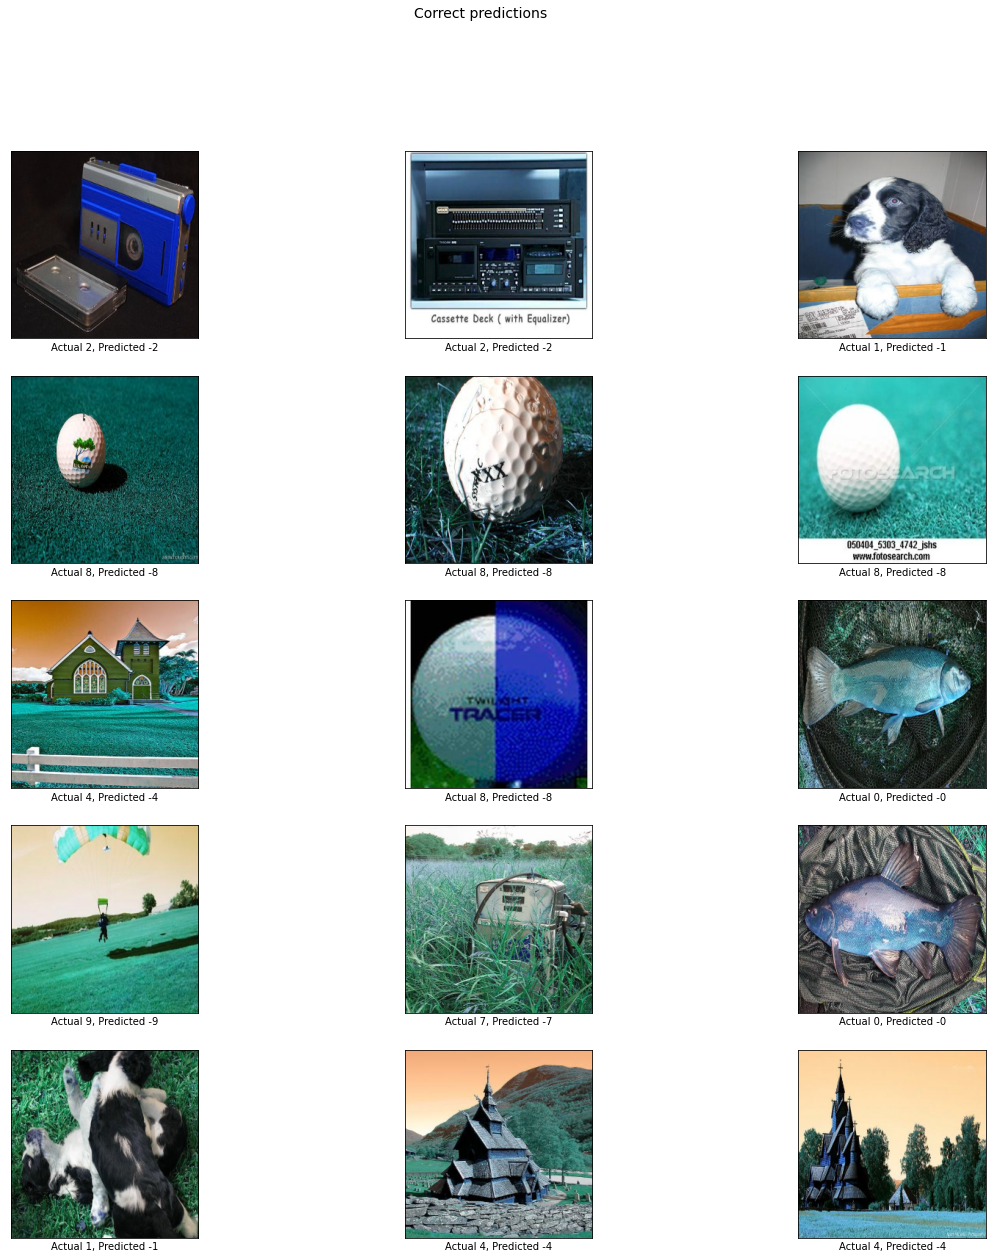

In [ ]:
X, y, z = shuffle(validation_generator.filenames,validation_generator.labels,predictions)
correct_pred_indices = (y == z)
filenames = []
for i,(filename,index) in enumerate(zip(X,correct_pred_indices)):
    if index:
      filenames.append(X[i])
X = np.asarray(filenames)
display_output("Correct predictions",X,y[correct_pred_indices],z[correct_pred_indices])

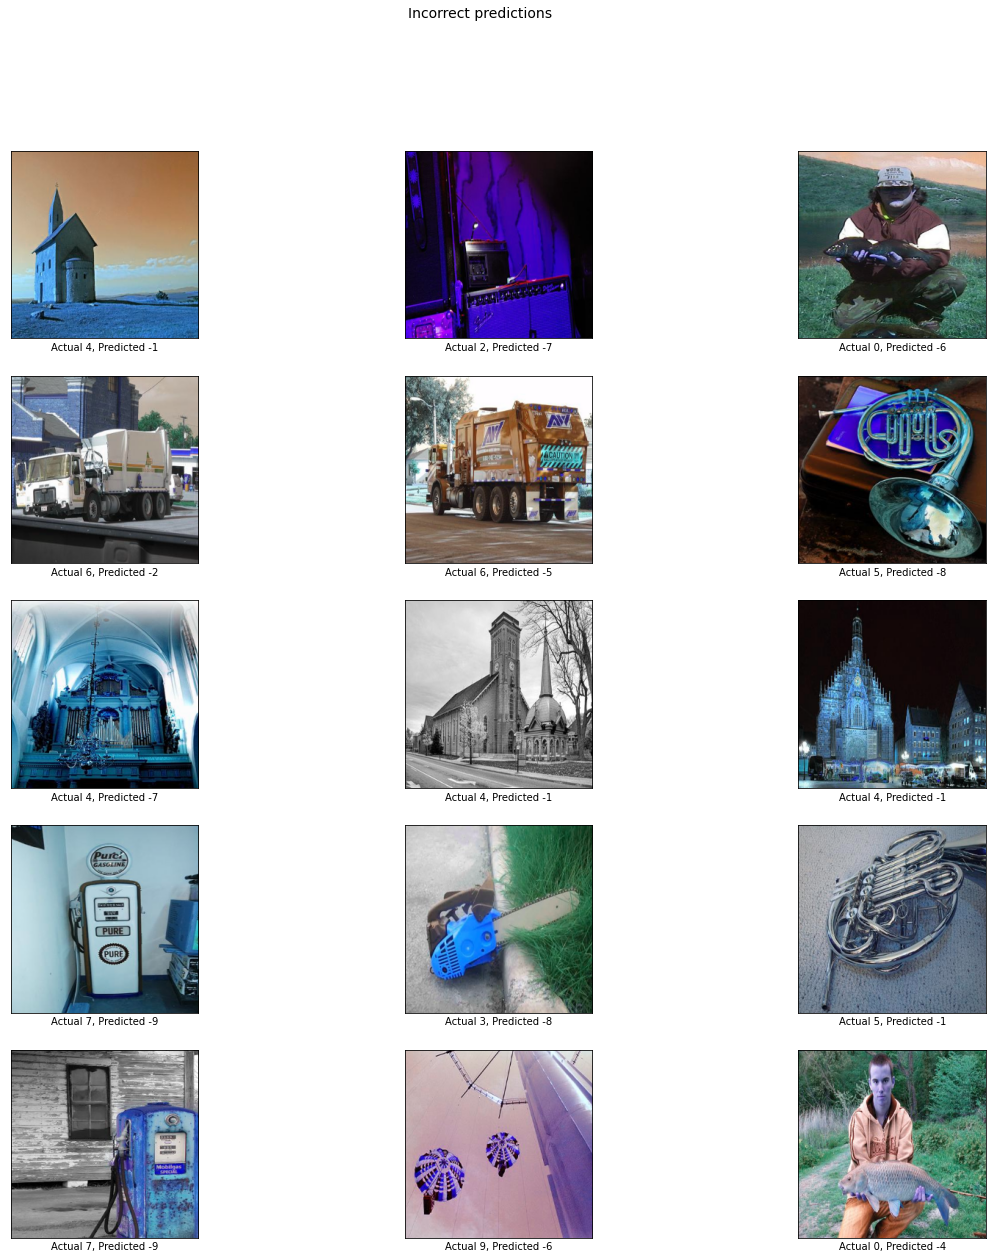

In [ ]:
X, y, z = shuffle(validation_generator.filenames,validation_generator.labels,predictions)
incorrect_pred_indices = (y != z)
filenames = []
for i,(filename,index) in enumerate(zip(X,incorrect_pred_indices)):
    if index:
      filenames.append(X[i])
X = np.asarray(filenames)
display_output("Incorrect predictions",X,y[incorrect_pred_indices],z[incorrect_pred_indices])